In [1]:
import numpy as np
import math
import csv
import time

import queue
from statistics import mean
import matplotlib.pyplot as plt
import random
import statistics
import scipy.stats as sct
from tabulate import tabulate
from scipy.sparse import lil_matrix

In [15]:
## NEW

N = 256
T = 128
arr_rate = 0.7
pb = 0.2
ps = 1-pb
lambda_s = (arr_rate*ps)
lambda_b = (arr_rate*pb)
mu_s = 1
mu_b = 0.5

'''N = 256
T = 64
arr_rate = 1.3
pb = 0.05
ps = 1-pb
lambda_s = (arr_rate*ps)
lambda_b = (arr_rate*pb)
mu_s = 1
mu_b = 0.02'''

'''N = 15
T = 5
arr_rate = 4
ps = 0.9
pb = 0.1
lambda_s = (arr_rate*ps)
lambda_b = (arr_rate*pb)
mu_s = 10
mu_b = 3'''

start_sim = time.time()

d1 = round(N + ((N*N)/(2*T)) - (N/2) + (N/T) + 1)
d2 = round((T)*(N/T) + 1)
#print(d1)
#print(d2)

q_dim = d1+(d2*(T+2))
q = lil_matrix((q_dim,q_dim))
#q = csc_matrix(q)
#print(q)

def access_q(n1,s1,b1,n2,s2,b2):
    global q
    if n1 == 0:
        pass
    elif n2 == 0:
        pass
    elif n1 == T+1:
        pass
    else:
        return ((-1,-1))
    
    q_dim = ((q.shape[0]-d1)/d2)

    row = access_map[(s1,b1)]
    col = access_map[(s2,b2)]
    if (n1>0):
        row = d1 + ((n1-1)*d2) + access_map_v2[(s1,b1)]
    if (n2>0):
        col = d1 + ((n2-1)*d2) + access_map_v2[(s2,b2)]
    return((row,col))


access_map = dict()
i = 0
for s in range(N+1):
    for b in range(round(N/T)+1):
        if (s+(b*T)) <= N:
            access_map[(s,b)] = i
            i = i+1

access_map_v2 = dict()
i = 0
for s in range(N+1):
    for b in range(round(N/T)+1):
        if (s+(b*T)) > (N-T) and (s+(b*T)) <= N:
            access_map_v2[(s,b)] = i
            i = i+1

def init_transitions_arr(dim):
    global q
    for n in range(dim):
        for s in range(N+1):
            for b in range (N+1):
                    
                if n > 0 and (s,b) in access_map_v2:
                    r,c = access_q(n,s,b, n+1,s,b)
                    q[r,c] = arr_rate
                elif n == 0:
                    if (s+(b*T)) == N:
                        r,c = access_q(0,s,b, 1,s,b)
                        q[r,c] = arr_rate
                    elif (s+(b*T)) <= (N-T):
                        r,c = access_q(0,s,b, 0,s+1,b)
                        q[r,c] = lambda_s
                        r,c = access_q(0,s,b, 0,s,b+1)
                        q[r,c] = lambda_b
                    elif (s+(b*T)) > (N-T) and (s+(b*T)) < N:
                        r,c = access_q(0,s,b, 0,s+1,b)
                        q[r,c] = lambda_s
                        r,c = access_q(0,s,b, 1,s,b)
                        q[r,c] = lambda_b

def init_transitions_srv(dim):
    global q
    for n in range(dim):
        for s in range(N+1):
            for b in range (N+1):
                F = N - (b*T) - s

                if n > 0 and (s+(b*T)) == N:
                    K = min(n,T)
                    if s > 0:
                        r,c = access_q(n,s,b, n-1,s,b)
                        q[r,c] = q[r,c] + (s*mu_s*ps)

                        r,c = access_q(n,s,b, n,s-1,b)
                        q[r,c] = q[r,c] + (s*mu_s*pb)
                    if b > 0:
                        r,c = access_q(n,s,b, n-1,s,b)
                        q[r,c] = q[r,c] + (b*mu_b*pb)

                        for i in range(1,K):
                            r,c = access_q(n,s,b, n-i,s+i,b-1)
                            q[r,c] = q[r,c] + (b*mu_b*math.pow(ps,i)*pb)

                        r,c = access_q(n,s,b, n-K,s+K,b-1)
                        q[r,c] = q[r,c] + (b*mu_b*math.pow(ps,K))


                elif n > 0 and F > 0 and F < (T-1):
                    K = min(F,n-1)
                    if s > 0:
                        r,c = access_q(n,s,b, n,s-1,b)
                        q[r,c] = q[r,c] + (s*mu_s)
                    if b > 0:
                        for i in range(0,K):
                            r,c = access_q(n,s,b, n-i-1,s+i,b)
                            q[r,c] = q[r,c] + (b*mu_b*math.pow(ps,i)*pb)

                        r,c = access_q(n,s,b, n-K-1,s+K,b)
                        q[r,c] = q[r,c] + (b*mu_b*math.pow(ps,K))

                elif n > 0 and F == (T-1):
                    K = min(F,n-1)
                    if s > 0:
                        r,c = access_q(n,s,b, n-1,s-1,b+1)
                        q[r,c] = q[r,c] + (s*mu_s)
                    if b > 0:
                        for i in range(0,K):
                            r,c = access_q(n,s,b, n-i-1,s+i,b)
                            q[r,c] = q[r,c] + (b*mu_b*math.pow(ps,i)*pb)

                        r,c = access_q(n,s,b, n-K-1,s+K,b)
                        q[r,c] = q[r,c] + (b*mu_b*math.pow(ps,K))

                elif n == 0 and (s+(b*T)) <= N:
                    if s > 0:
                        r,c = access_q(0,s,b, 0,s-1,b)
                        q[r,c] = q[r,c] + (s*mu_s)
                    if b > 0:
                        r,c = access_q(0,s,b, 0,s,b-1)
                        q[r,c] = q[r,c] + (b*mu_b)

def fill_diagonal():
    for i in range(q.shape[0]):
        q[i,i] = -(np.sum(q[i])-q[i,i])
    

init_transitions_arr(T+2)
init_transitions_srv(T+2)
fill_diagonal()

#q = csr_matrix(q).toarray()

diag = d1 + (d2*T)

Bs = []
for i in range(1,T+1):
    block = q[diag:diag+d2, diag-(d2*i):diag-(d2*i)+d2].toarray()
    Bs.append(block)

L = q[diag:diag+d2, diag:diag+d2].toarray()
F = q[diag:diag+d2, diag+d2:diag+d2+d2].toarray()
L_prime = q[0:d1,0:d1].toarray()
F_prime = q[0:d1,d1:d1+d2].toarray()
Bs_prime = [q[d1:d1+d2,0:d1].toarray()]
for i in range(T-1):
    Bs_prime.append(q[d1+((i+1)*d2) : d1+((i+1)*d2)+d2 , 0:d1].toarray())
    
print("Generating time --- %s seconds ---" % (time.time() - start_sim))

L_inv = np.linalg.inv(L)
V = np.matmul(F,L_inv)
Ws = []
for B in Bs:
    W = np.matmul(B,L_inv)
    Ws.append(W)
Ws

Rs = [np.zeros((d2,d2))]
diff = 1
i = 0
while diff > 1e-12:    
    R = -V
    j = 2
    for W in Ws:
        R = np.subtract(R,np.matmul(np.linalg.matrix_power(Rs[i],j),W))
        j += 1
    diff = R[0][0] - Rs[-1][0][0]
    Rs.append(R)
    i += 1
R = Rs[-1]
print(len(Rs))

#
tl = L_prime
tr = F_prime
bl = Bs_prime[0]
for i in range(1,len(Bs_prime)):
    b = Bs_prime[i]
    bl = np.add(bl,np.matmul(np.linalg.matrix_power(R,i),b))
br = L
#i = 1
for i in range(len(Bs)):
    b = Bs[i]
    br = np.add(br,np.matmul(np.linalg.matrix_power(R,i+1),b))
'''for b in Bs:
    br = np.add(br,np.matmul(np.linalg.matrix_power(R,i),b))
    i += 1'''


#
bc = np.append(tl,tr,axis=1)
bcb = np.append(bl,br,axis=1)
bc = np.append(bc,bcb,axis=0)
bc[0][-1] = 1
for r in bc[1:]:
    r[-1] = 0

#
a = np.transpose(bc)
b = np.zeros(d1+d2)
b[-1] = 1
raw_pi = np.linalg.solve(a,b)

#
ir = np.linalg.inv(np.subtract(np.identity(R.shape[0]),R))
r = np.matmul(raw_pi[d1:],ir)
alfa = np.sum(raw_pi[:d1]) + np.sum(r)
pi = raw_pi/alfa
pis = [pi[:d1],pi[d1:]]
for i in range(2,max(N,100)):
    pis.append(np.matmul(pis[i-1],R))
    
print("Total time --- %s seconds ---" % (time.time() - start_sim))

pis

Generating time --- 10.021114587783813 seconds ---
27
Total time --- 18.282866716384888 seconds ---


[array([4.26739297e-01, 1.17513534e-01, 1.39490474e-02, 2.39960741e-01,
        6.73236922e-02, 6.76487034e-02, 1.98855101e-02, 1.27769098e-02,
        4.14462577e-03, 1.82974484e-03, 7.33408218e-04, 2.15605432e-04,
        1.33375607e-04, 2.29343419e-05, 2.93982867e-05, 2.60312931e-06,
        7.98931971e-06, 4.00775546e-07, 2.45182117e-06, 8.92315830e-08,
        7.93786053e-07, 2.44219024e-08, 2.63469818e-07, 7.23725087e-09,
        8.87400481e-08, 2.21912882e-09, 3.02027420e-08, 6.94515732e-10,
        1.03641375e-08, 2.20720332e-10, 3.58043954e-09, 7.10293529e-11,
        1.24390406e-09, 2.31003390e-11, 4.34236116e-10, 7.58124503e-12,
        1.52219711e-10, 2.50788842e-12, 5.35543229e-11, 8.35518673e-13,
        1.89021572e-11, 2.80211088e-13, 6.69065409e-12, 9.46262864e-14,
        2.37432782e-12, 3.22412862e-14, 8.44556787e-13, 1.11568731e-14,
        3.01070978e-13, 3.99280351e-15, 1.07562267e-13, 1.54373056e-15,
        3.85253975e-14, 6.99046411e-16, 1.38498743e-14, 4.027819

In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 13 14:32:38 2023

@author: dilettaolliaro
"""

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 10 16:15:17 2023

@author: dilettaolliaro
"""

import numpy as np
import math
import csv
import time

import queue
from statistics import mean
import matplotlib.pyplot as plt
import random
import statistics
import scipy.stats as sct

# +
N = 15
T = 5
arr_rate = 4
ps = 0.9
pb = 0.1
lambda_s = (arr_rate*ps)
lambda_b = (arr_rate*pb)
mu_s = 10
mu_b = 3

N = 256
T = 128
arr_rate = 0.7
pb = 0.2
ps = 1-pb
lambda_s = (arr_rate*ps)
lambda_b = (arr_rate*pb)
mu_s = 1
mu_b = 0.5

def t(i):
    return tuple(i)

start_sim = time.time()

d1 = int(N + ((N*N)/(2*T)) - (N/2) + (N/T) + 1)
d2 = int((T)*(N/T) + 1)

map_d1 = dict()
i = 0
for s in range(N+1):
    for b in range(int(N/T)+1):
        if (s+(b*T)) <= N:
            map_d1[(s,b)] = i
            i = i+1
            
map_d2 = dict()
i = 0
for s in range(N+1):
    for b in range(int(N/T)+1):
        if (s+(b*T)) > (N-T) and (s+(b*T)) <= N:
            map_d2[(s,b)] = i
            i = i+1
     
F = np.zeros((d2, d2))

for i in map_d2.keys():
    for j in map_d2.keys():     
        if i == j:
            F[map_d2[i]][map_d2[j]] = arr_rate
     
F_prime = np.zeros((d1, d2))

for i in map_d1.keys():
    for j in map_d2.keys():
        if i == j: 
            if i[0]+T*(i[1]) == N:
                F_prime[map_d1[i]][map_d2[j]] = arr_rate
            if i[0]+T*(i[1]) > N-T and i[0]+T*(i[1]) < N:
                F_prime[map_d1[i]][map_d2[j]] = lambda_b

L_prime = np.zeros((d1, d1))
for x in map_d1.keys():
    i = np.array(x)
    for y in map_d1.keys():
        j = np.array(y)
        if list(j) == list(i + np.array([1,0])) and  i[0]+T*(i[1]) < N:
            L_prime[map_d1[x]][map_d1[y]] = lambda_s
        elif list(j) == list(i + np.array([0,1])) and i[0]+T*(i[1]) <= N-T:
            L_prime[map_d1[x]][map_d1[y]] = lambda_b
        elif list(j) == list(i - np.array([1,0])):  
            L_prime[map_d1[x]][map_d1[y]] = i[0]*mu_s
        elif list(j) == list(i - np.array([0,1])):  
            L_prime[map_d1[x]][map_d1[y]] = i[1]*mu_b
        elif list(j) == list(i):
            L_prime[map_d1[x]][map_d1[y]] = -(1)*(arr_rate+i[0]*mu_s+i[1]*mu_b)

Bs = []
B_1 = np.zeros((d2, d2))
for i in map_d2.keys():
    for j in map_d2.keys(): 
        Fr = N - (i[0]+T*(i[1]))
        
        if i[0]+T*(i[1]) == N:
           if i == j: 
               B_1[map_d2[i]][map_d2[j]] = i[0]*mu_s*ps
           if j[0] == i[0] + 1 and j[1] == i[1] - 1:   
               B_1[map_d2[i]][map_d2[j]] = i[1]*mu_b*pb*ps

        elif Fr == T-1:
            if j[0] == i[0] - 1 and j[1] == i[1] + 1:
                B_1[map_d2[i]][map_d2[j]] = i[0]*mu_s
        elif i == j:
            B_1[map_d2[i]][map_d2[j]] += i[1]*mu_b*pb
  
Bs.append(B_1)            
  
for l in range(2, T+1):           
    B_l = np.zeros((d2, d2))
    for x in map_d2.keys():
        i = np.array(x)
        for y in map_d2.keys():
            Fr = N-(i[0]+T*i[1])
            j = np.array(y)
            if i[0]+T*(i[1]) == N:
                if list(j) == list(i + np.array([l, -1])):
                    B_l[map_d2[x]][map_d2[y]] = i[1]*mu_b*(ps**l)*pb
                elif list(j) == list(i + np.array([T, -1])) and T == l:
                    B_l[map_d2[x]][map_d2[y]] = i[1]*mu_b*(ps**T)
            
            elif Fr <= T-1 and Fr != 0:
                if list(j) == list(i + np.array([l-1, 0])):
                    B_l[map_d2[x]][map_d2[y]] = i[1]*mu_b*(ps**(l-1))*pb
                elif list(j) == list(i + np.array([Fr, 0])) and l-1 == Fr:
                    B_l[map_d2[x]][map_d2[y]] = i[1]*mu_b*(ps**(Fr))
    Bs.append(B_l)
            
L = np.zeros((d2, d2))
for x in map_d2.keys():
    i = np.array(x)
    for y in map_d2.keys():
        j = np.array(y)
        Fr = N-(i[0]+T*i[1])
        if i[0]+T*(i[1]) == N and list(j) == list(i + np.array([-1, 0])):
            L[map_d2[x]][map_d2[y]] = i[0]*mu_s*pb
        elif Fr < T-1 and Fr != 0 and list(j) == list(i + np.array([-1, 0])):
            L[map_d2[x]][map_d2[y]] = i[0]*mu_s
        elif x == y:
            L[map_d2[x]][map_d2[y]] = -(1)*(arr_rate+i[0]*mu_s+i[1]*mu_b)

Bs_prime = []

B1_prime = np.zeros((d2, d1))
for x in map_d2.keys():
    i = np.array(x)
    for y in map_d1.keys(): 
        j = np.array(y)
        Fr = N-(i[0]+T*i[1])
        if i[0]+T*(i[1]) == N:
           if x == y:
               B1_prime[map_d2[x]][map_d1[y]] = i[0]*mu_s*ps+i[1]*mu_b*pb
           elif list(j) == list(i+np.array([+1,-1])):
               B1_prime[map_d2[x]][map_d1[y]] = i[1]*mu_b*ps
        elif Fr != 0 and Fr <= T-1:
            if x == y:
                B1_prime[map_d2[x]][map_d1[y]] = i[1]*mu_b
        elif Fr == T-1:
            if list(j) == list(i+np.array([-1,+1])):
                B1_prime[map_d2[x]][map_d1[y]] = i[0]*mu_s    

Bs_prime.append(B1_prime)

for l in range(2, T+1):
    Bl_prime = np.zeros((d2, d1))
    for x in map_d2.keys():
        i = np.array(x)
        for y in map_d1.keys():
            j = np.array(y)
            Fr = N-(i[0]+T*i[1])
            if i[0]+T*(i[1]) == N and list(j) == list(i + np.array([l, -1])):   
                Bl_prime[map_d2[x]][map_d1[y]] = i[1]*mu_b*(ps**l)
            elif Fr <= T-1 and Fr != 0 and list(j) == list(i + np.array([l-1, 0])):   
                Bl_prime[map_d2[x]][map_d1[y]] = i[1]*mu_b*(ps**(l-1))
    Bs_prime.append(Bl_prime)
    
print("Generating time --- %s seconds ---" % (time.time() - start_sim))

                
L_inv = np.linalg.inv(L)
V = np.matmul(F,L_inv)
Ws = []
for B in Bs:
    W = np.matmul(B,L_inv)
    Ws.append(W)


Rs = [np.zeros((d2,d2))]
diff = 1
i = 0
while diff > 1e-12:    
    R = -V
    j = 2
    for W in Ws:
        R = np.subtract(R,np.matmul(np.linalg.matrix_power(Rs[i],j),W))
        j += 1
    diff = R[0][0] - Rs[-1][0][0]
    Rs.append(R)
    i += 1
print(len(Rs))
R = Rs[-1]

#
tl = L_prime
tr = F_prime
bl = Bs_prime[0]
for i in range(1,len(Bs_prime)):
    b = Bs_prime[i]
    bl = np.add(bl,np.matmul(np.linalg.matrix_power(R,i),b))
br = L
#i = 1
for i in range(len(Bs)):
    b = Bs[i]
    br = np.add(br,np.matmul(np.linalg.matrix_power(R,i+1),b))

bc = np.append(tl,tr,axis=1)
bcb = np.append(bl,br,axis=1)
bc = np.append(bc,bcb,axis=0)
bc[0][-1] = 1
for r in bc[1:]:
    r[-1] = 0

#
a = np.transpose(bc)
b = np.zeros(d1+d2)
b[-1] = 1
pi = np.linalg.solve(a,b)

#
ir = np.linalg.inv(np.subtract(np.identity(R.shape[0]),R))
r = np.matmul(pi[d1:],ir)
alfa = np.sum(pi[:d1]) + np.sum(r)
pi = pi/alfa
pis = [pi[:d1],pi[d1:]]
for i in range(2,101):
    pis.append(np.matmul(pis[i-1],R))
    
print("Total time --- %s seconds ---" % (time.time() - start_sim))
    
pis

Generating time --- 133.43209719657898 seconds ---
3
Total time --- 134.61906957626343 seconds ---


[array([4.17578020e-01, 1.09570593e-01, 9.63118277e-03, 2.37519317e-01,
        6.33926061e-02, 6.91214226e-02, 1.90484673e-02, 1.46975966e-02,
        4.25796615e-03, 3.38603191e-03, 1.01097163e-03, 1.43564202e-03,
        3.99110574e-04, 1.01457106e-03, 2.58488491e-04, 8.37774616e-04,
        2.03701174e-04, 7.22606770e-04, 1.71384731e-04, 6.36870306e-04,
        1.48616411e-04, 5.69867397e-04, 1.31294338e-04, 5.15935146e-04,
        1.17545065e-04, 4.71545244e-04, 1.06323159e-04, 4.34349180e-04,
        9.69754249e-05, 4.02716480e-04, 8.90635458e-05, 3.75477663e-04,
        8.22788386e-05, 3.51771166e-04, 7.63962426e-05, 3.30947815e-04,
        7.12472717e-05, 3.12508936e-04, 6.67030876e-05, 2.96064988e-04,
        6.26634066e-05, 2.81307178e-04, 5.90489729e-05, 2.67987510e-04,
        5.57963072e-05, 2.55904490e-04, 5.28539618e-05, 2.44892693e-04,
        5.01797960e-05, 2.34815017e-04, 4.77389612e-05, 2.25556862e-04,
        4.55023885e-05, 2.17021682e-04, 4.34456384e-05, 2.091275

In [31]:
np.savetxt("L.csv", L, delimiter = ",")
np.savetxt("F.csv", F, delimiter = ",")
np.savetxt("L_prime.csv", L_prime, delimiter = ",")
np.savetxt("F_prime.csv", F_prime, delimiter = ",")
i = 1
for b in Bs:
    np.savetxt("B"+str(i)+".csv", b, delimiter = ",")
    i+=1
i = 1
for bp in Bs_prime:
    np.savetxt("B"+str(i)+"_prime.csv", bp, delimiter = ",")
    i+=1

In [38]:
N_ao[0]

0.5903640519292633

In [21]:
pis

[array([ 6.10565079e-01,  8.14096340e-02,  5.41449247e-03,  2.07446125e-04,
         2.19803141e-01,  2.93154452e-02,  1.97140560e-03,  3.95631680e-02,
         5.27690976e-03,  3.53323705e-04,  4.74646644e-03,  6.33191720e-04,
         4.27178360e-05,  4.26321977e-04,  5.69081223e-05,  3.97370851e-06,
         3.00032684e-05,  4.01641027e-06,  3.18619311e-07,  1.22280249e-06,
         1.69218702e-07, -4.32286615e-07, -5.46842820e-08, -4.52840570e-07,
        -5.81154070e-08, -4.03422554e-07, -5.19518786e-08, -3.61356384e-07,
        -4.66590353e-08, -3.27170597e-07, -2.99778515e-07, -2.76881201e-07,
        -2.57306199e-07, -2.40368798e-07]),
 array([ 7.37387664e-05,  4.64637749e-05,  5.28914944e-06,  4.83578282e-07,
         3.90122443e-08,  3.44829439e-08, -6.49568980e-10, -1.64877799e-09,
        -1.31544823e-09, -1.01338247e-09, -7.74955981e-09, -3.60118911e-08,
        -3.31187251e-08, -3.06677641e-08, -2.85623418e-08, -2.67336982e-07]),
 array([ 2.51228314e-05,  1.06208914e-05, 

In [22]:
def check_stability():
    A = np.add(F,L)
    for b in Bs:
        A = np.add(A,b)
    #print(A)
    
    a = np.transpose(A)
    a[-1] = np.ones(A.shape[0])
    b = np.zeros(A.shape[0])
    b[-1] = 1
    pi_A = np.linalg.solve(a,b)
    
    stable = False
    asc = np.sum(np.matmul(pi_A,F))
    desc = np.sum(np.matmul(pi_A,Bs[0]))
    #print(desc)
    #print(np.sum(np.matmul(pi_A,L)))
    for b in Bs[1:]:
        desc +=  np.sum(np.matmul(pi_A,b))
    #print(asc)
    #print(desc)
    #print(pi_A)
    if asc < desc:
        stable = True
    return stable

check_stability()

True

In [16]:
## SOLVING

start_sim = time.time()

#N total (average occupancy)

mLz = np.array([
    [s[0] for s in access_map],
    [s[1] for s in access_map]
])
mL_t = []
mL_b = []
for s in access_map_v2:
    if s[0] + (s[1]*T) < N:
        mL_t.append(s[0])
        mL_b.append(s[1]+1) #HOL
    elif s[0] + (s[1]*T) == N:
        mL_t.append(s[0] + ps)
        mL_b.append(s[1] + pb)
mL = np.array([
    mL_t,
    mL_b
])

Nl = np.matmul(mLz,pis[0])

Nrl = np.matmul(np.transpose(pis[1]),np.matmul(R,np.linalg.matrix_power(np.subtract(np.identity(R.shape[0]),R),-2)))
Nrl = np.sum(Nrl)
Nrl = np.array([ps,pb])*Nrl

Nrr = np.matmul(np.transpose(pis[1]),np.linalg.inv(np.subtract(np.identity(R.shape[0]),R)))

Nrr = np.matmul(mL,np.transpose(Nrr))

Nr = np.add(Nrl,Nrr)
N_ao = np.add(Nl,Nr)

#T
RT = np.sum(N_ao)/arr_rate
RTs = N_ao[0]/lambda_s
RTb = N_ao[1]/lambda_b

# U

Ht = []
Hb = []
for s in access_map_v2:
    Ht.append(s[0])
    Hb.append(s[1])
H = np.array([
    Ht,
    Hb
])

Bl = np.matmul(mLz,pis[0])
Bl = np.matmul(Bl,np.array([1,T]))

Br = np.matmul(np.transpose(pis[1]),np.linalg.inv(np.subtract(np.identity(R.shape[0]),R)))
Br = np.matmul(Br,np.transpose(H))
Br = np.matmul(Br,np.array([1,T]))

B = Bl + Br

U = B/N

#Ns (jobs in service)

Nsl = np.matmul(mLz,pis[0])

Nsr = np.matmul(np.transpose(pis[1]),np.linalg.inv(np.subtract(np.identity(R.shape[0]),R)))
Nsr = np.matmul(Nsr,np.transpose(H))

Nst = np.add(Nsl,Nsr)

#Nw (jobs waiting)

mLw_t = []
mLw_b = []
for s in access_map_v2:
    if s[0] + (s[1]*T) < N:
        mLw_t.append(0)
        mLw_b.append(1) #HOL
    elif s[0] + (s[1]*T) == N:
        mLw_t.append(ps)
        mLw_b.append(pb)
mLw = np.array([
    mLw_t,
    mLw_b
])

Nwl = Nrl

Nwr = np.matmul(np.transpose(pis[1]),np.linalg.inv(np.subtract(np.identity(R.shape[0]),R)))

Nwr = np.matmul(mLw,np.transpose(Nwr))

Nwt = np.add(Nwl,Nwr)


print("Total time --- %s seconds ---" % (time.time() - start_sim))

Total time --- 0.2339494228363037 seconds ---


In [47]:
Nwt

array([0.03036405, 0.01942171])

array([[0, 1, 2, 3, 4],
       [2, 1, 1, 0, 0]])

Arrival rate: 0.7


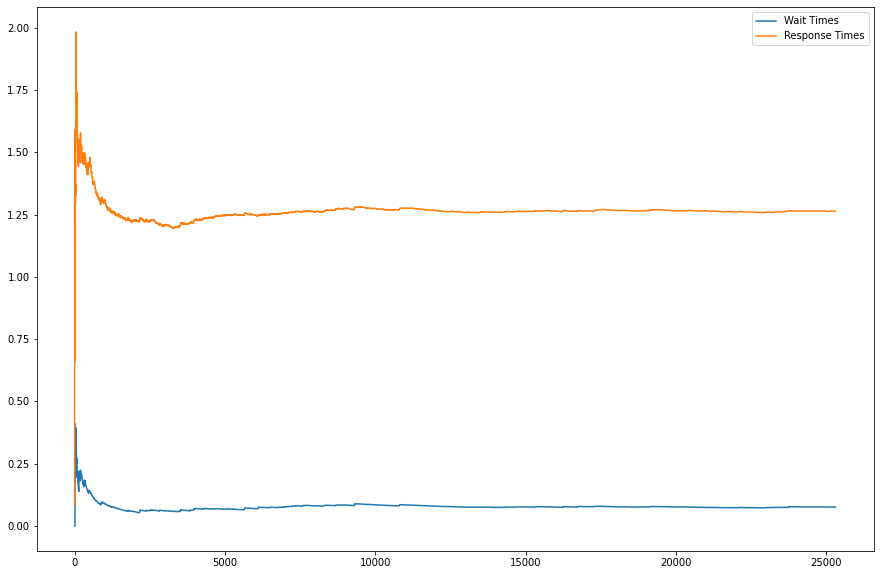

Utilization: 0.14189174044108352
Small job throughput: 0.5626111111111111
Big job throughput: 0.14027777777777778
Average number of small job in srv: 0.5550775015695187
Average number of big job in srv: 0.2794469379011554
Average number of small job in waiting: 0.03238066510466571
Average number of big job in waiting: 0.021191600574356394
Average number of small job total: 0.5874581666741845
Average number of big job total: 0.30063853847551175
Total time --- 6.181026935577393 seconds ---
------------
Arrival rate: 0.7


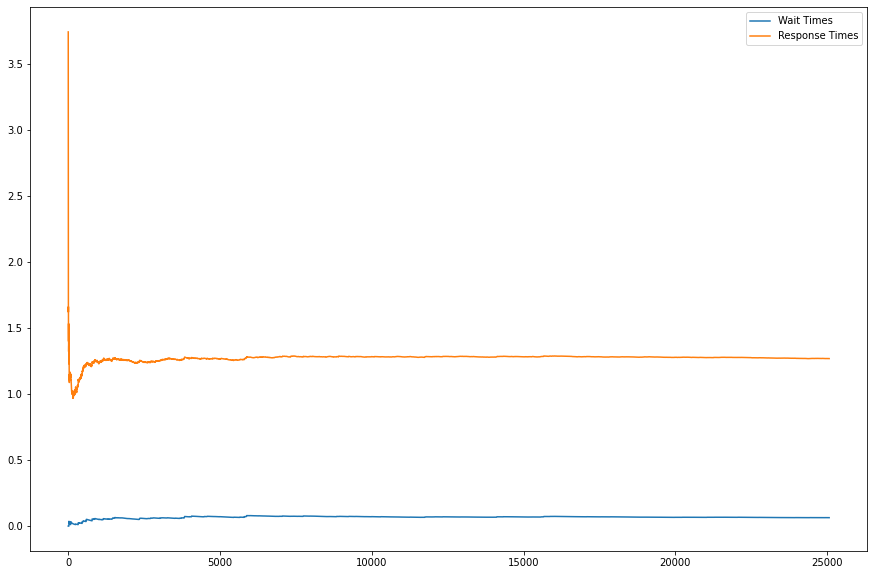

Utilization: 0.14446312040580353
Small job throughput: 0.5549722222222222
Big job throughput: 0.14144444444444446
Average number of small job in srv: 0.5551332662649349
Average number of big job in srv: 0.2845892621689154
Average number of small job in waiting: 0.027150084811833265
Average number of big job in waiting: 0.017335382686912492
Average number of small job total: 0.5822833510767681
Average number of big job total: 0.3019246448558279
Total time --- 6.103005647659302 seconds ---
------------
Arrival rate: 0.7


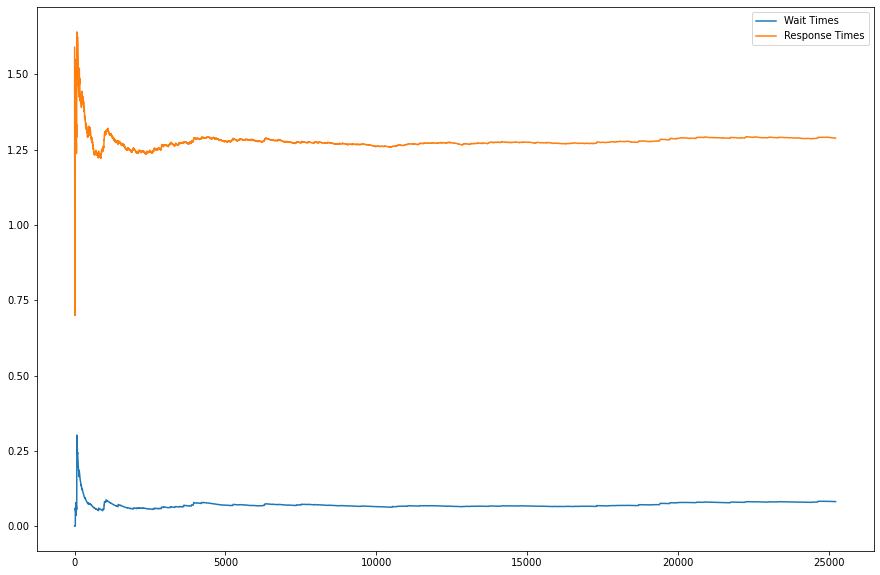

Utilization: 0.1461405195661716
Small job throughput: 0.5606666666666666
Big job throughput: 0.14016666666666666
Average number of small job in srv: 0.5579187908228004
Average number of big job in srv: 0.28792229857903867
Average number of small job in waiting: 0.0357658658616986
Average number of big job in waiting: 0.021273508207161902
Average number of small job total: 0.593684656684499
Average number of big job total: 0.30919580678620057
Total time --- 6.08540153503418 seconds ---
------------
Arrival rate: 0.7


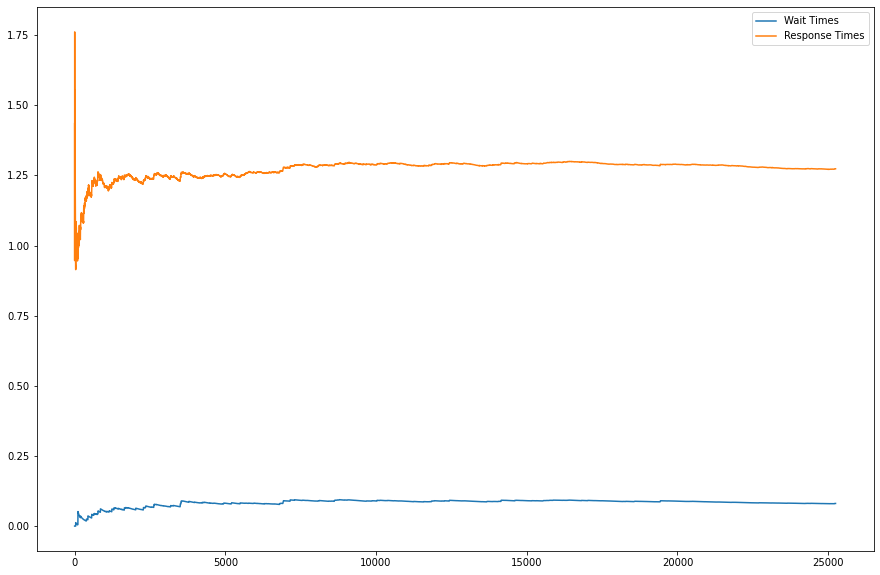

Utilization: 0.14489982737415616
Small job throughput: 0.5594722222222223
Big job throughput: 0.14180555555555555
Average number of small job in srv: 0.5508812949389889
Average number of big job in srv: 0.2854958946316017
Average number of small job in waiting: 0.034958077139204485
Average number of big job in waiting: 0.021637685043330298
Average number of small job total: 0.5858393720781934
Average number of big job total: 0.307133579674932
Total time --- 6.1597161293029785 seconds ---
------------
Arrival rate: 0.7


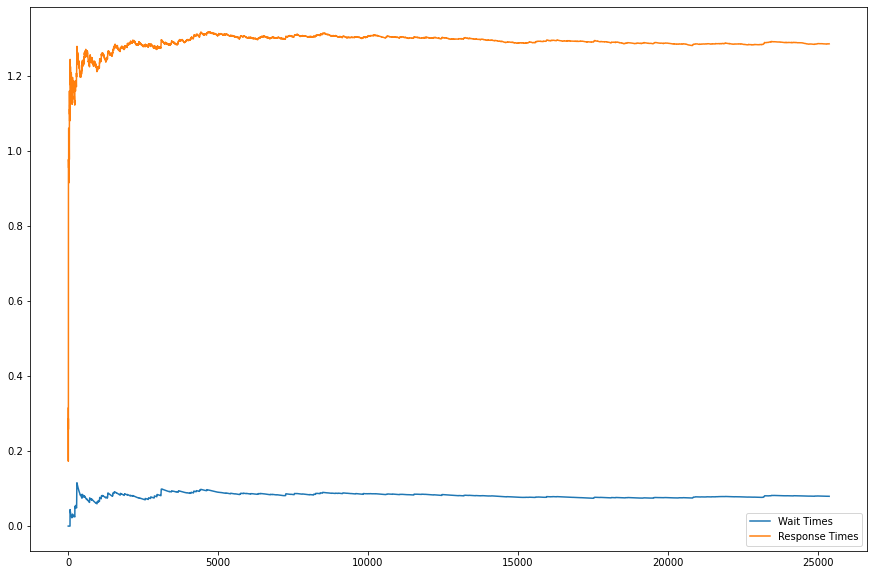

Utilization: 0.14436214349081306
Small job throughput: 0.5632777777777778
Big job throughput: 0.14177777777777778
Average number of small job in srv: 0.5653500469060455
Average number of big job in srv: 0.2843074897401728
Average number of small job in waiting: 0.033259160734209675
Average number of big job in waiting: 0.022689665337911665
Average number of small job total: 0.5986092076402552
Average number of big job total: 0.30699715507808445
Total time --- 6.177264213562012 seconds ---
------------
Arrival rate: 0.7


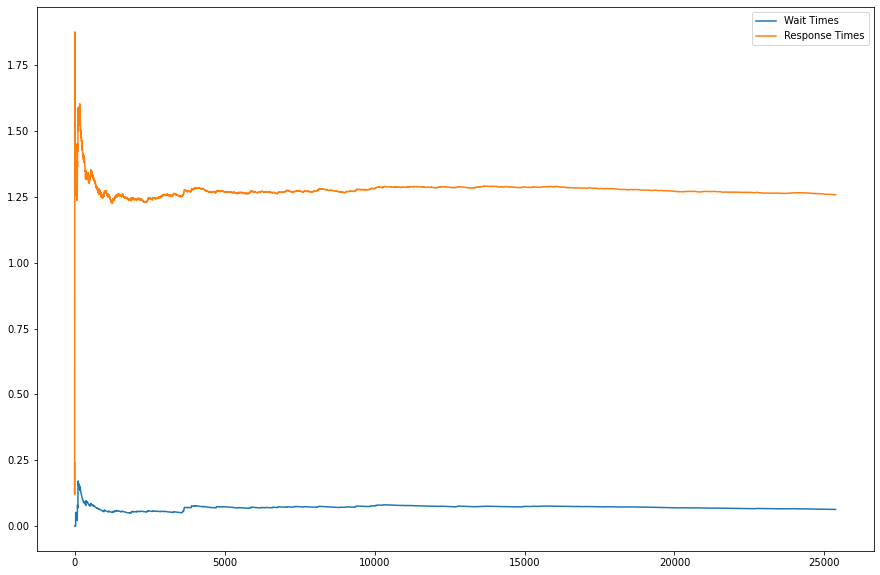

Utilization: 0.14335306920671262
Small job throughput: 0.5645555555555556
Big job throughput: 0.14019444444444445
Average number of small job in srv: 0.5598841781021161
Average number of big job in srv: 0.282332043272005
Average number of small job in waiting: 0.026644791161740115
Average number of big job in waiting: 0.017993688972468475
Average number of small job total: 0.5865289692638562
Average number of big job total: 0.30032573224447345
Total time --- 6.150986671447754 seconds ---
------------
Arrival rate: 0.7


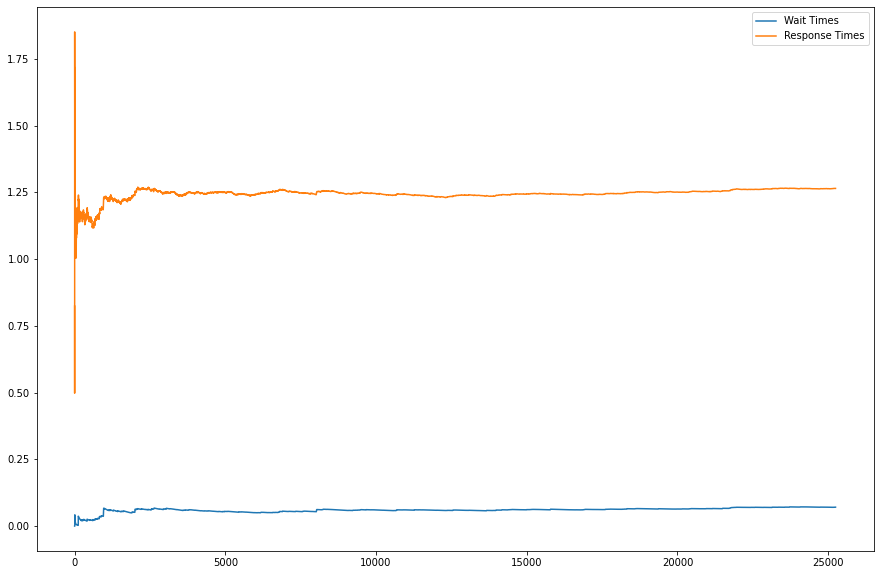

Utilization: 0.13975246478923325
Small job throughput: 0.5625
Big job throughput: 0.13875
Average number of small job in srv: 0.562312908396979
Average number of big job in srv: 0.2751118599816145
Average number of small job in waiting: 0.02979054926755392
Average number of big job in waiting: 0.019900256038099896
Average number of small job total: 0.5921034576645329
Average number of big job total: 0.29501211601971444
Total time --- 6.16981840133667 seconds ---
------------
Arrival rate: 0.7


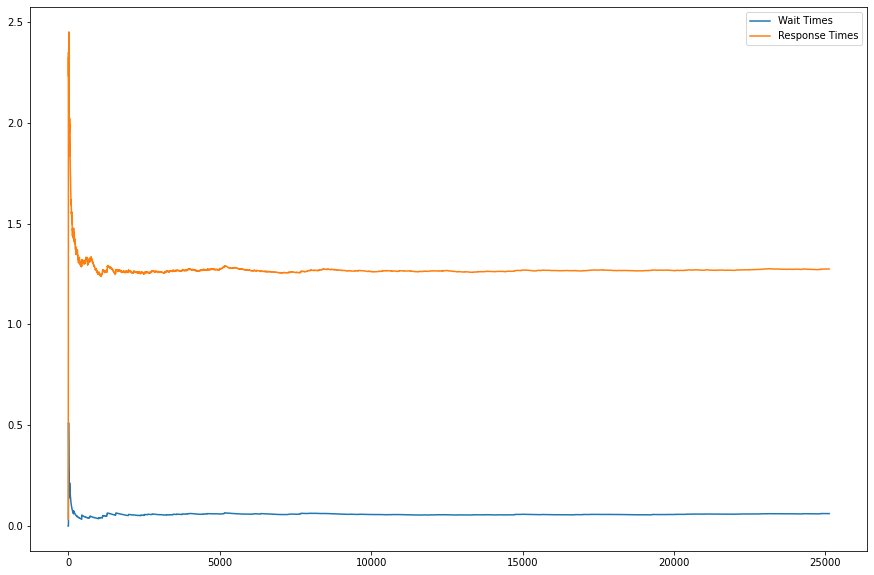

Utilization: 0.14215963355721484
Small job throughput: 0.5597222222222222
Big job throughput: 0.13825
Average number of small job in srv: 0.5667552925160885
Average number of big job in srv: 0.27989149139164843
Average number of small job in waiting: 0.027076344910824737
Average number of big job in waiting: 0.016168892423460035
Average number of small job total: 0.5938316374269133
Average number of big job total: 0.29606038381510846
Total time --- 6.118229866027832 seconds ---
------------
Arrival rate: 0.7


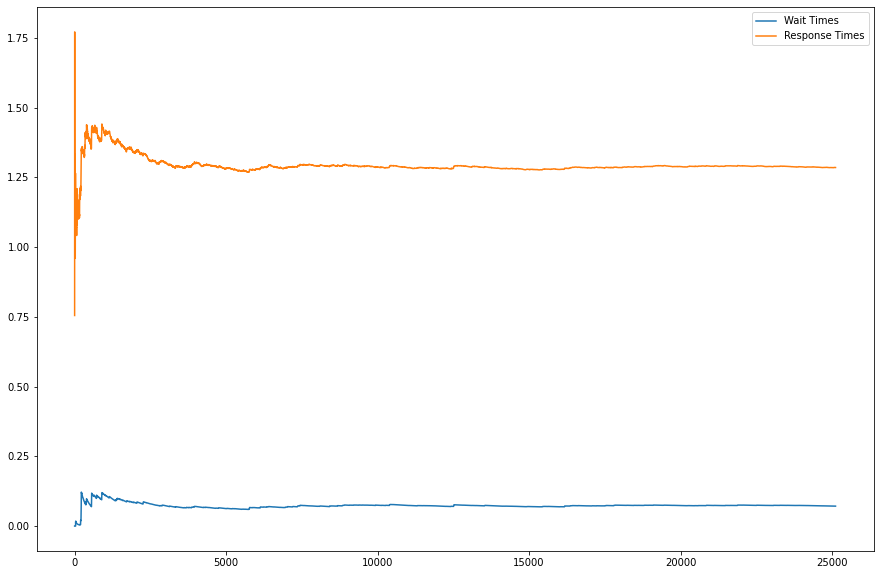

Utilization: 0.1435524458292095
Small job throughput: 0.5559722222222222
Big job throughput: 0.1416388888888889
Average number of small job in srv: 0.563913627190899
Average number of big job in srv: 0.28269931644598933
Average number of small job in waiting: 0.029013540526203013
Average number of big job in waiting: 0.02088062528658229
Average number of small job total: 0.592927167717102
Average number of big job total: 0.30357994173257163
Total time --- 6.1072845458984375 seconds ---
------------
Arrival rate: 0.7


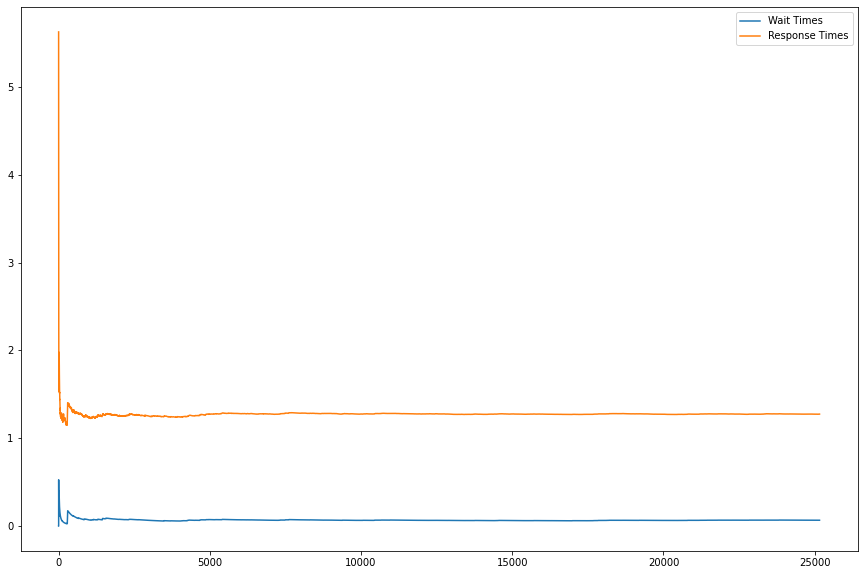

Utilization: 0.14091199407450367
Small job throughput: 0.5623888888888889
Big job throughput: 0.13652777777777778
Average number of small job in srv: 0.5667911594299345
Average number of big job in srv: 0.2773959322159625
Average number of small job in waiting: 0.02896235209021788
Average number of big job in waiting: 0.017678870638999533
Average number of small job total: 0.5957535115201524
Average number of big job total: 0.295074802854962
Total time --- 6.199984312057495 seconds ---
------------
Arrival rate: 0.7


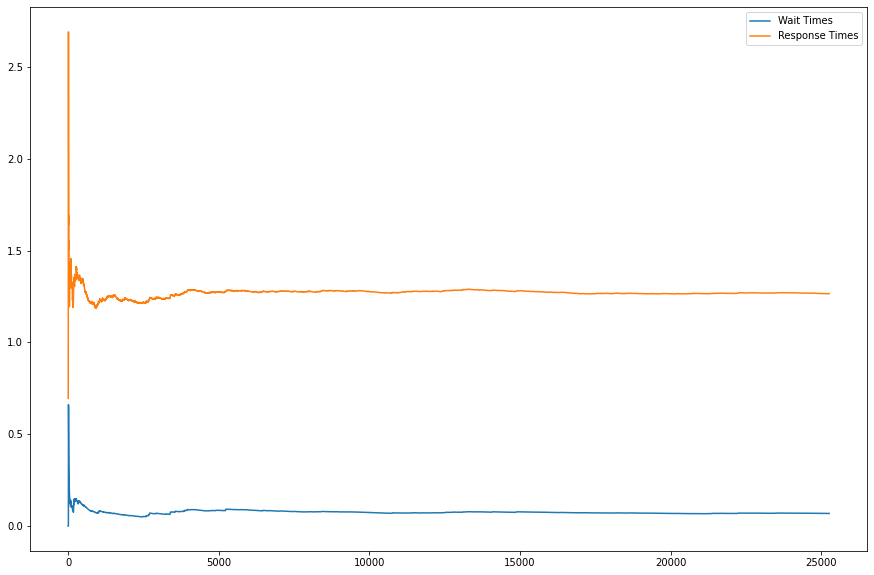

Utilization: 0.14509338353815698
Small job throughput: 0.5583333333333333
Big job throughput: 0.14333333333333334
Average number of small job in srv: 0.5542899763799751
Average number of big job in srv: 0.28585637663584523
Average number of small job in waiting: 0.02837010381711858
Average number of big job in waiting: 0.01995645227068315
Average number of small job total: 0.5826600801970937
Average number of big job total: 0.3058128289065284
Total time --- 6.346088409423828 seconds ---
------------
Arrival rate: 0.7


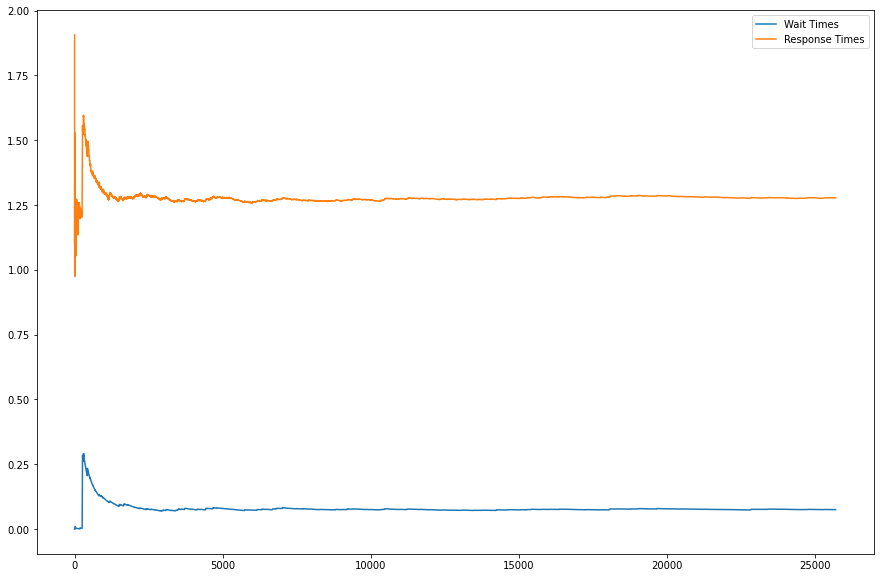

Utilization: 0.1431006791851522
Small job throughput: 0.5740277777777778
Big job throughput: 0.13994444444444445
Average number of small job in srv: 0.5769200094771771
Average number of big job in srv: 0.28169417079626197
Average number of small job in waiting: 0.03154961946902865
Average number of big job in waiting: 0.022059726736761574
Average number of small job total: 0.6084696289462058
Average number of big job total: 0.30375389753302356
Total time --- 6.301082611083984 seconds ---
------------
Arrival rate: 0.7


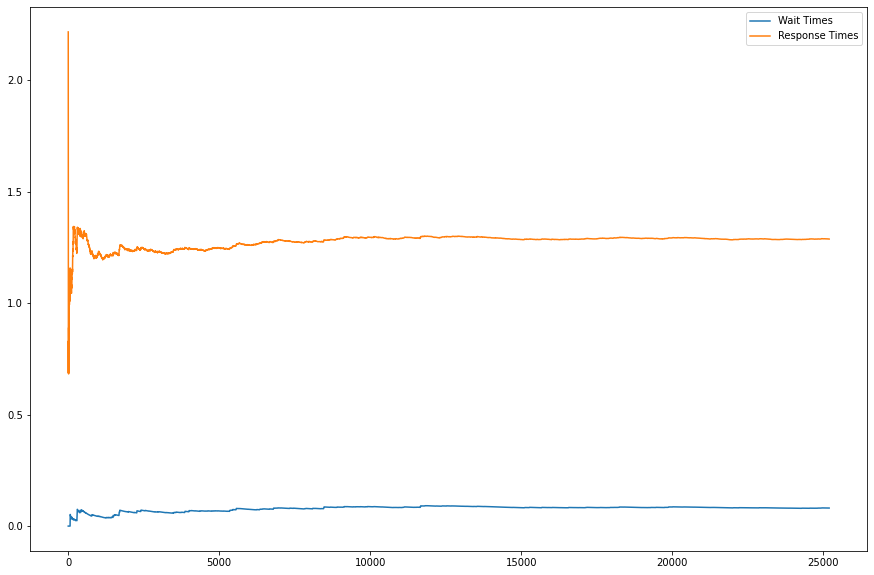

Utilization: 0.1450995409256029
Small job throughput: 0.5588333333333333
Big job throughput: 0.1411388888888889
Average number of small job in srv: 0.5582840968869707
Average number of big job in srv: 0.2858374873442745
Average number of small job in waiting: 0.03433493695535319
Average number of big job in waiting: 0.022306086778744245
Average number of small job total: 0.5926190338423238
Average number of big job total: 0.30814357412301874
Total time --- 6.099538087844849 seconds ---
------------
Arrival rate: 0.7


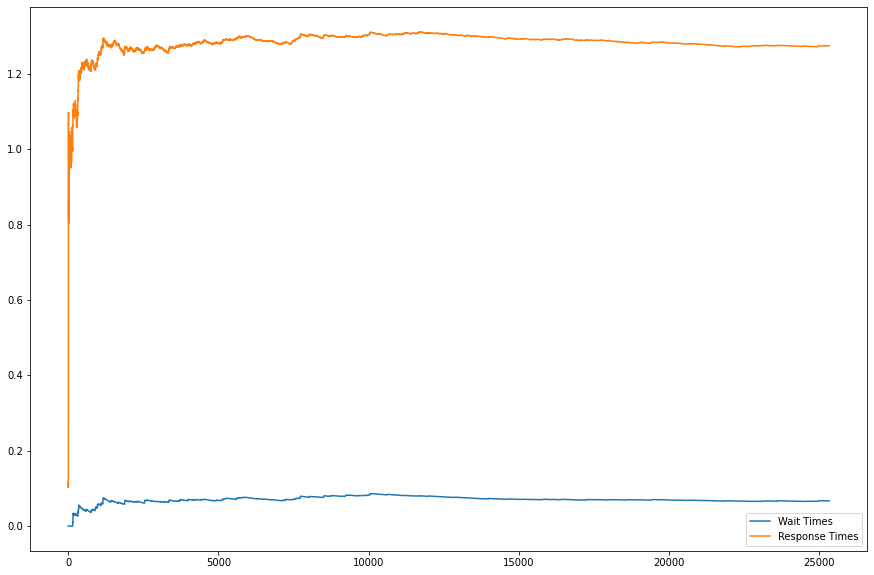

Utilization: 0.1431471025995424
Small job throughput: 0.5641944444444444
Big job throughput: 0.13947222222222222
Average number of small job in srv: 0.5678371556465479
Average number of big job in srv: 0.28185797742059465
Average number of small job in waiting: 0.02781111303418026
Average number of big job in waiting: 0.019273592819193473
Average number of small job total: 0.5956482686807282
Average number of big job total: 0.30113157023978815
Total time --- 6.169867753982544 seconds ---
------------
Arrival rate: 0.7


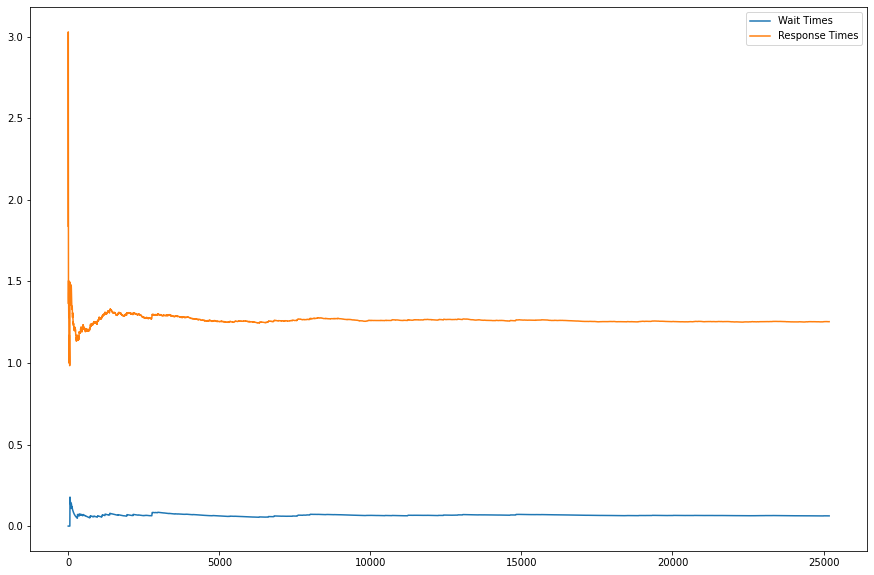

Utilization: 0.13561233773780723
Small job throughput: 0.5631944444444444
Big job throughput: 0.13647222222222222
Average number of small job in srv: 0.565890553441448
Average number of big job in srv: 0.2668036555268521
Average number of small job in waiting: 0.026011566651379558
Average number of big job in waiting: 0.017817248837728922
Average number of small job total: 0.5919021200928276
Average number of big job total: 0.284620904364581
Total time --- 6.008611440658569 seconds ---
------------
Arrival rate: 0.7


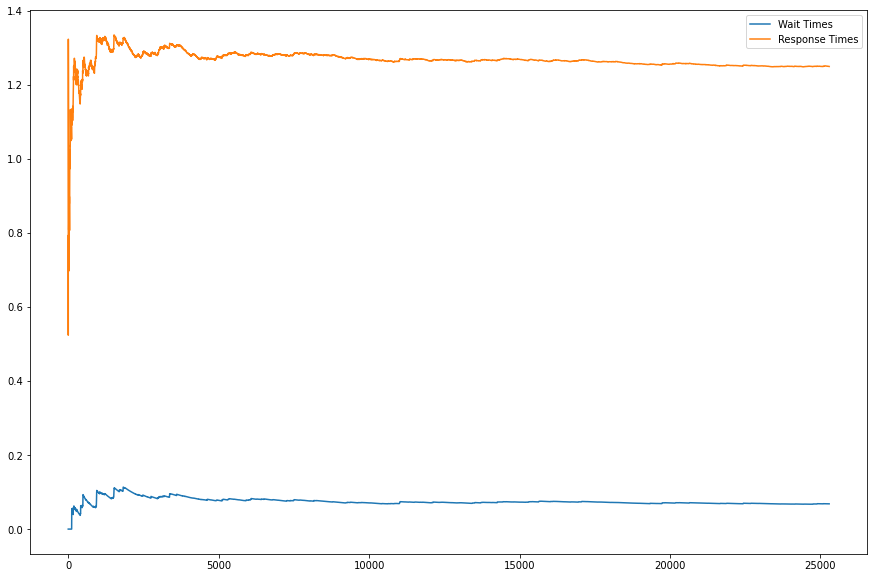

Utilization: 0.1389910484264409
Small job throughput: 0.5613333333333334
Big job throughput: 0.14116666666666666
Average number of small job in srv: 0.5561989502431391
Average number of big job in srv: 0.2736367925541086
Average number of small job in waiting: 0.029532149800364494
Average number of big job in waiting: 0.018377025728270435
Average number of small job total: 0.5857311000435036
Average number of big job total: 0.29201381828237905
Total time --- 6.209313154220581 seconds ---
------------
Arrival rate: 0.7


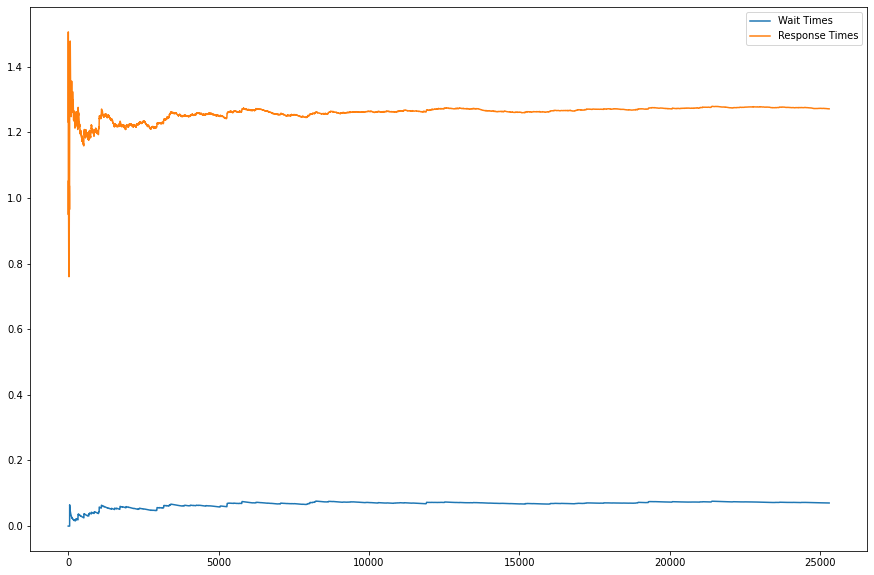

Utilization: 0.14383024992540216
Small job throughput: 0.5633611111111111
Big job throughput: 0.1395
Average number of small job in srv: 0.560964096392652
Average number of big job in srv: 0.28327796784773784
Average number of small job in waiting: 0.03022542341806193
Average number of big job in waiting: 0.019267457766552778
Average number of small job total: 0.5911895198107139
Average number of big job total: 0.3025454256142906
Total time --- 6.098726987838745 seconds ---
------------
Arrival rate: 0.7


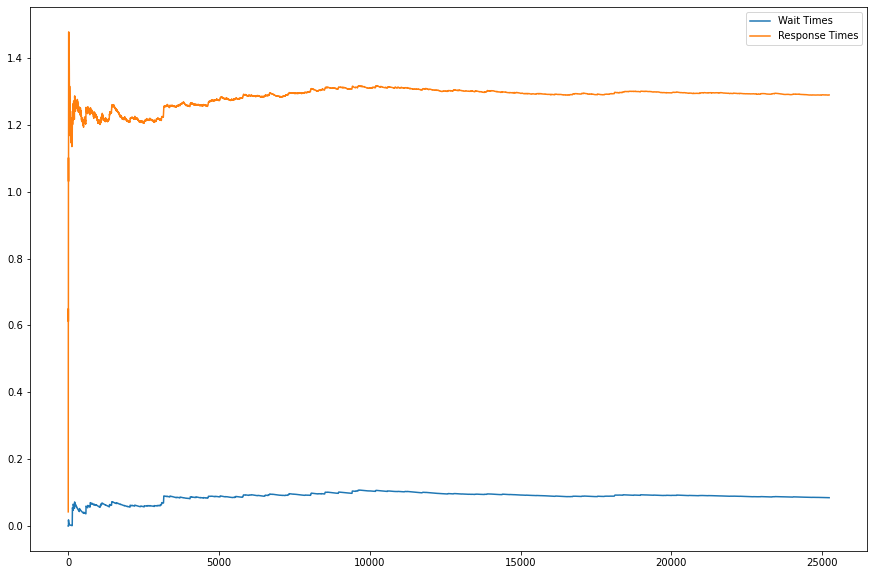

Utilization: 0.14640128117892182
Small job throughput: 0.5605833333333333
Big job throughput: 0.14030555555555554
Average number of small job in srv: 0.5557490335054096
Average number of big job in srv: 0.28846077303358075
Average number of small job in waiting: 0.03709421879337357
Average number of big job in waiting: 0.022441230775237957
Average number of small job total: 0.5928432522987832
Average number of big job total: 0.3109020038088187
Total time --- 6.184295177459717 seconds ---
------------
Arrival rate: 0.7


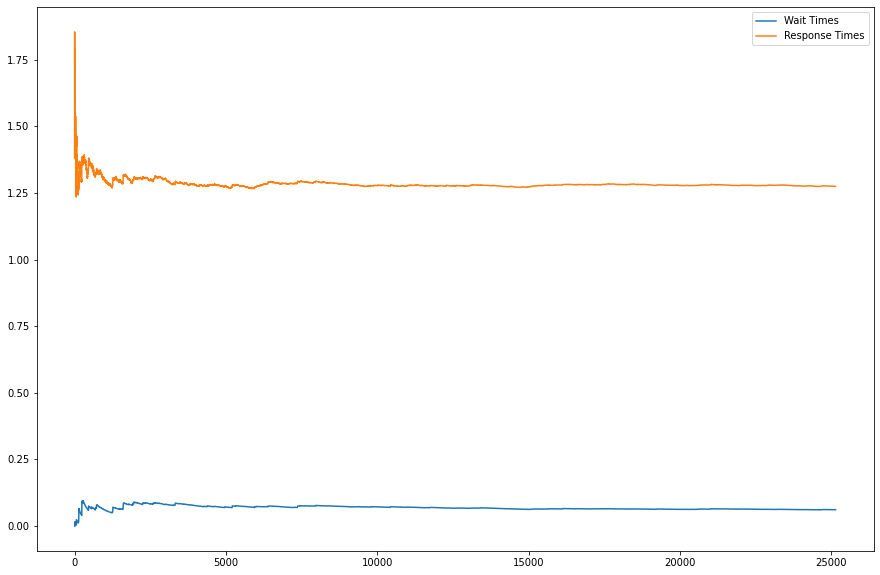

Utilization: 0.1390020816753265
Small job throughput: 0.5618055555555556
Big job throughput: 0.13647222222222222
Average number of small job in srv: 0.5736969417114646
Average number of big job in srv: 0.2735221559935326
Average number of small job in waiting: 0.02522919147533783
Average number of big job in waiting: 0.017677434227437817
Average number of small job total: 0.5989261331868024
Average number of big job total: 0.2911995902209704
Total time --- 6.128713607788086 seconds ---
------------
Arrival rate: 0.7


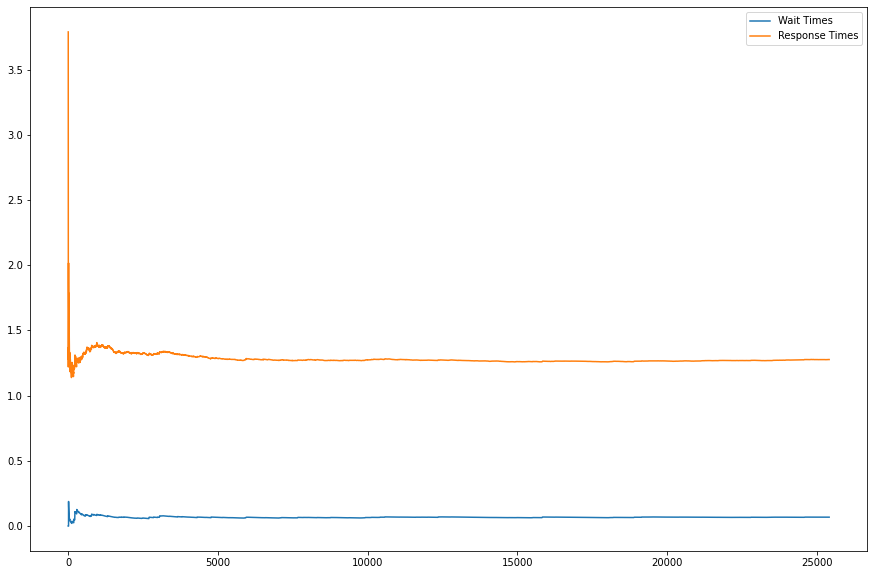

Utilization: 0.13933221125926815
Small job throughput: 0.5688333333333333
Big job throughput: 0.13694444444444445
Average number of small job in srv: 0.5787238767096118
Average number of big job in srv: 0.2741431422317459
Average number of small job in waiting: 0.029084529260068565
Average number of big job in waiting: 0.019183022489611835
Average number of small job total: 0.6078084059696803
Average number of big job total: 0.29332616472135775
Total time --- 6.377132415771484 seconds ---
------------


In [7]:
##SIMULATION

def avl_server(t,servers):
    low = len(servers)
    i = 0
    for s in servers:
        if t > s[1]:
            if low == len(servers):
                low = i
            elif s[1] < servers[low][1]:
                low = i
        i += 1
    if low < len(servers):
        return low #return server with earliest idle time
    return len(servers)

def get_avl_servers(t,servers,n):
    empty = []
    i = 0
    for s in servers:
        if t >= s[1]: #get empty servers
            empty.append((i,s[1]))
        i += 1
    empty.sort(key = lambda x: x[1])
    return empty[:n] #return the [server index,free time]

def busy_server_n(t,servers):
    n = 0
    i = 0
    jobs = dict()
    jobs['big'] = []
    jobs['small'] = []
    jobs[''] = []
    for s in servers:
        if s[1] == 0:
            continue
        if t < s[1] and t >= s[0]: #get busy server
            n += 1
            job_type = s[2].split('_')[0]
            jobs[job_type].append(s[2])
        i+=1
    big_job_n = len(list(set(jobs['big'])))
    small_job_n = len(list(set(jobs['small'])))
    return (n,small_job_n,big_job_n) #reverse

def queue_counter(q,big_job_size):
    small_jobs = 0
    big_jobs = 0
    for job in q:
        if job[1] == big_job_size:
            big_jobs += 1
        else:
            small_jobs += 1
    return ((small_jobs,big_jobs))

def get_job_size(max_size, pb):
    limit = pb*100
    randn = random.randint(1,100)
    if randn > limit:
        return 1
    return max_size

def get_srv_rate(job_size):
    if job_size == 1:
        return mu_s
    elif job_size == T:
        return mu_b

measurements = []
for run in range(20):
    start_sim = time.time()
    max_job_size = T
    server_start = 0

    duration = 3600*10
    #job_size = 10

    server_n = N
    #srv_rate = 5

    # POPULATE THE JOBS ARRIVAL TIMES AND JOB SIZE
    t = 0
    jobs_arr_t = []
    while t <= duration:
        iat = np.random.exponential(1/arr_rate)
        t += iat
        #jobs_arr_t.append((t,random.choice([1,job_size])))
        jobs_arr_t.append((t,get_job_size(max_job_size,pb)))

    waiting_times = []
    response_times = []
    queue = []

    # INITIATE THE N SERVERS
    servers = [] #[service_start,end]
    for s in range(server_n):
        servers.append([0,server_start,''])

    server_load = [[0,0]]
    queue_size = [[0,0]]
    jobs_inside = [[0,0,0]]
    jobs_queue = [[0,0,0]]
    throughput_small = 0
    throughput_big = 0
    nsb = [(0,0,0,0)]

    job_id = 0
    # ITERATE EVENT-BASED (CAN BE JOBS ARRIVAL OR SERVICE FINISHED)
    while job_id < len(jobs_arr_t):
        t = 999999999
        curr_job = jobs_arr_t[job_id] 
        # ITERATE ALL THE SERVERS AND GET THE NEXT EARLIEST SERVER FINISH
        for s in servers:
            if s[1] > 0 and s[1] < t and s[1] > server_load[-1][0]:
                t = s[1]
        # GET THE NEXT JOBS ARRIVAL
        if jobs_arr_t[job_id][0] < t:
            t = jobs_arr_t[job_id][0]
            queue.append(curr_job)
            job_id += 1
        # NOW, t IS THE NEXT EVENT HAPPENING
        #print(t)

        # HOL TECHNIQUE WHERE SCHEDULERS PRIORITIZE THE JOBS AT THE FRONT,
        # AND WAIT UNTIL HOWEVER MANY SERVERS THAT JOB NEEDS ARE AVAILABLE
        while len(queue) > 0:
            job = queue[0] #only the job at the front
            avl_servers_n = len(servers)-busy_server_n(t,servers)[0] #get the number of available servers
            if avl_servers_n >= job[1]: #if it's enough for the job at the front
                ready_servers = get_avl_servers(t,servers,job[1]) #get all the servers ready to service
                st = np.random.exponential(1/get_srv_rate(job[1])) #determine the service rate
                for s in ready_servers:# put the job in each ready server
                    server_id = s[0]
                    job_name = ''
                    if job[1] == max_job_size: #for graph purpose
                        job_name += 'big'
                    else:
                        job_name += 'small'
                    job_name += '_'+str(job[0])
                    servers[server_id] = [t,t+st,job_name]
                waiting_times.append((t-job[0],job[1])) #for graph purpose
                response_times.append((t+st-job[0],job[1])) #for graph purpose
                queue.pop(0)
                if job[1] == max_job_size: #for graph purpose
                    throughput_big += 1
                else:
                    throughput_small += 1
            else:
                break

        server_state = busy_server_n(t,servers)
        queue_state = queue_counter(queue,max_job_size)
        server_load.append((t,server_state[0])) #for graph purpose
        queue_size.append((t,len(queue))) #for graph purpose
        jobs_inside.append((t,server_state[1],server_state[2]))
        jobs_queue.append((t,queue_state[0],queue_state[1]))
        nsb.append((t,len(queue),server_state[1],server_state[2]))

    print('Arrival rate: '+str(arr_rate))
    
    avg_wait = []
    n = 1
    tot = 0
    for w in [wt[0] for wt in waiting_times]:
        tot += w
        avg_wait.append(tot/n)
        n += 1

    avg_resp = []
    avg_resp_s = 0
    avg_resp_b = 0
    n = 1
    tot = 0
    for w in [rt[0] for rt in response_times]:
        tot += w
        avg_resp.append(tot/n)
        n += 1
        
    for rt in response_times:
        if rt[1] == 1:
            avg_resp_s += rt[0]
        else:
            avg_resp_b += rt[0]
    avg_resp_s = avg_resp_s/throughput_small
    avg_resp_b = avg_resp_b/throughput_big

    plt.figure(figsize=(15,10))
    plt.plot([i for i in range(len(avg_wait))], avg_wait, label = "Wait Times")
    plt.plot([i for i in range(len(avg_resp))], avg_resp, label = "Response Times")
    plt.legend()
    plt.show()

    # counting the utilization
    util = 0 
    n_small = 0
    n_big = 0
    n_small_w = 0
    n_big_w = 0
    i = 1
    while i < len(server_load):
        if server_load[i-1][0] < server_start:
            i += 1
            continue
        timestamp = server_load[i][0] - server_load[i-1][0]
        load = server_load[i-1][1]
        small_load = jobs_inside[i-1][1]
        big_load = jobs_inside[i-1][2]
        small_queue = jobs_queue[i-1][1]
        big_queue = jobs_queue[i-1][2]
        util += (timestamp*load)
        n_small += (timestamp*small_load)
        n_big += (timestamp*big_load)
        n_small_w += (timestamp*small_queue)
        n_big_w += (timestamp*big_queue)
        i += 1
    duration -= server_start
    avg_util = util/duration/server_n
    avg_n_small = n_small/duration
    avg_n_big = n_big/duration
    avg_n_small_w = n_small_w/duration
    avg_n_big_w = n_big_w/duration
    avg_thr_small = throughput_small/duration
    avg_thr_big = throughput_big/duration
    measurements.append([nsb,avg_n_small,avg_n_big,
                         avg_n_small_w,avg_n_big_w,
                         avg_resp[-1],avg_resp_s,avg_resp_b,
                         avg_util])

    print('Utilization: '+str(avg_util))
    print('Small job throughput: '+str(avg_thr_small))
    print('Big job throughput: '+str(avg_thr_big))
    print('Average number of small job in srv: '+str(avg_n_small))
    print('Average number of big job in srv: '+str(avg_n_big))
    print('Average number of small job in waiting: '+str(avg_n_small_w))
    print('Average number of big job in waiting: '+str(avg_n_big_w))
    print('Average number of small job total: '+str(avg_n_small+avg_n_small_w))
    print('Average number of big job total: '+str(avg_n_big+avg_n_big_w))

    print("Total time --- %s seconds ---" % (time.time() - start_sim))
    print('------------')
    
nsbs = []
for m in measurements:
    nsb = m[0]
    stat = dict()
    last_t = 0
    last_st = (0,0,0)
    for st in nsb[1:]:
        if last_st in stat:
            stat[last_st] += (st[0]-last_t)
        else:
            stat[last_st] = (st[0]-last_t)
        last_t = st[0]
        last_st = (st[1],st[2],st[3])

    for st in stat:
        stat[st] = stat[st]/duration
        
    nsbs.append(stat)

In [17]:
## VALIDATION

conf_num = 0.95

measures = ['N - small', 'N - big',
            'Ns- small', 'Ns - big',
            'Nw- small', 'Nw - big',
            'Rt', 'Rt- small', 'Rt - big',
            'Utilization']

table = [['Measure', 'Matrix geom.', 'Sim. Estimate', 'Confidence Interval', 'Check']]
for i in range(1,3):
    sim_data = [m[i]+m[i+2] for m in measurements]
    mean = np.mean(sim_data)
    conf = sct.t.interval(alpha=conf_num, df=len(sim_data)-1, loc=mean, scale=sct.sem(sim_data))
    check = False
    if N_ao[i-1] > conf[0] and N_ao[i-1] < conf[1]:
        check = True
    table.append([measures[i-1], N_ao[i-1], mean, conf, check])
    
for i in range(3,5):
    sim_data = [m[i-2] for m in measurements]
    mean = np.mean(sim_data)
    conf = sct.t.interval(alpha=conf_num, df=len(sim_data)-1, loc=mean, scale=sct.sem(sim_data))
    check = False
    if Nst[i-3] > conf[0] and Nst[i-3] < conf[1]:
        check = True
    table.append([measures[i-1], Nst[i-3], mean, conf, check])
    
for i in range(5,7):
    sim_data = [m[i-2] for m in measurements]
    mean = np.mean(sim_data)
    conf = sct.t.interval(alpha=conf_num, df=len(sim_data)-1, loc=mean, scale=sct.sem(sim_data))
    check = False
    if Nwt[i-5] > conf[0] and Nwt[i-5] < conf[1]:
        check = True
    table.append([measures[i-1], Nwt[i-5], mean, conf, check])
    
for i in range(7,8):
    sim_data = [m[i-2] for m in measurements]
    mean = np.mean(sim_data)
    conf = sct.t.interval(alpha=conf_num, df=len(sim_data)-1, loc=mean, scale=sct.sem(sim_data))
    check = False
    resp_t = np.sum(N_ao)/arr_rate
    if resp_t > conf[0] and resp_t < conf[1]:
        check = True
    table.append([measures[i-1], resp_t, mean, conf, check])
    
for i in range(8,10):
    sim_data = [m[i-2] for m in measurements]
    mean = np.mean(sim_data)
    conf = sct.t.interval(alpha=conf_num, df=len(sim_data)-1, loc=mean, scale=sct.sem(sim_data))
    check = False
    lam = lambda_s
    if i == 9:
        lam = lambda_b
    resp_t = N_ao[i-8]/lam
    if resp_t > conf[0] and resp_t < conf[1]:
        check = True
    table.append([measures[i-1], resp_t, mean, conf, check])
    
for i in range(10,11):
    sim_data = [m[i-2] for m in measurements]
    mean = np.mean(sim_data)
    conf = sct.t.interval(alpha=conf_num, df=len(sim_data)-1, loc=mean, scale=sct.sem(sim_data))
    check = False
    resp_t = U
    if resp_t > conf[0] and resp_t < conf[1]:
        check = True
    table.append([measures[i-1], resp_t, mean, conf, check])

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════╤════════════════╤═════════════════╤══════════════════════════════════════════════╤═════════╕
│ Measure     │   Matrix geom. │   Sim. Estimate │ Confidence Interval                          │ Check   │
╞═════════════╪════════════════╪═════════════════╪══════════════════════════════════════════════╪═════════╡
│ N - small   │      0.590364  │       0.592841  │ (0.5895413466753623, 0.5961403574061497)     │ True    │
├─────────────┼────────────────┼─────────────────┼──────────────────────────────────────────────┼─────────┤
│ N - big     │      0.299422  │       0.30047   │ (0.2972044744960272, 0.30373477343918714)    │ True    │
├─────────────┼────────────────┼─────────────────┼──────────────────────────────────────────────┼─────────┤
│ Ns- small   │      0.56      │       0.562629  │ (0.559022779694363, 0.5662344959589072)      │ True    │
├─────────────┼────────────────┼─────────────────┼──────────────────────────────────────────────┼─────────┤
│ Ns - big    │      0.28   

In [202]:
res = [['State','Matrix Geom.','Simulation','Diff', 'Check']]
#res = [['State','Truncated matrix']]
i = 0
for st in access_map:
    mg = pis[0][i]
    
    sim_data = [0,0,0,0,0]
    try:
        sim_data = [nsb[(0,st[0],st[1])] for nsb in nsbs]
    except KeyError:
        i += 1
        continue
    
    mean = np.mean(sim_data)
    conf = sct.t.interval(alpha=0.95, df=len(sim_data)-1, loc=mean, scale=sct.sem(sim_data))
    check = True
    diff = '-'
    if mg < conf[0]:
        check = False
        diff = '{:.1%}'.format((conf[0]-mg)/mg)
    elif mg > conf[1]:
        check = False
        diff = '{:.1%}'.format((mg-conf[1])/mg)
    
    res.append([(0,st[0],st[1]),mg,conf,diff, check])
    #res.append([[0,st[0],st[1]],trunc_pis[i]])
    i += 1

for j in range(1,len(pis)):
    i = 0
    for st in access_map_v2:
        mg = pis[j][i]
        
        sim_data = [0,0,0,0,0]
        try:
            sim_data = [nsb[(j,st[0],st[1])] for nsb in nsbs]
        except KeyError:
            i += 1
            continue
        mean = np.mean(sim_data)
        conf = sct.t.interval(alpha=0.95, df=len(sim_data)-1, loc=mean, scale=sct.sem(sim_data))
        check = True
        diff = '-'
        if mg < conf[0]:
            check = False
            diff = '{:.1%}'.format((conf[0]-mg)/mg)
        elif mg > conf[1]:
            check = False
            diff = '{:.1%}'.format((mg-conf[1])/mg)

        res.append([(j,st[0],st[1]),mg, conf,diff, check])
        #res.append([[j,st[0],st[1]],trunc_pis[d1+((j-1)*5)+i]])
        i += 1
    
print(tabulate(res, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════╤════════════════╤═════════════════════════════════════════════════╤════════╤═════════╕
│ State     │   Matrix Geom. │ Simulation                                      │ Diff   │ Check   │
╞═══════════╪════════════════╪═════════════════════════════════════════════════╪════════╪═════════╡
│ (0, 0, 0) │    0.951229    │ (0.9510686088188397, 0.9515399988724326)        │ -      │ True    │
├───────────┼────────────────┼─────────────────────────────────────────────────┼────────┼─────────┤
│ (0, 0, 1) │    0.00951229  │ (0.009367430256405627, 0.009560860124152947)    │ -      │ True    │
├───────────┼────────────────┼─────────────────────────────────────────────────┼────────┼─────────┤
│ (0, 0, 2) │    4.75615e-05 │ (4.022146550710223e-05, 5.191680157134582e-05)  │ -      │ True    │
├───────────┼────────────────┼─────────────────────────────────────────────────┼────────┼─────────┤
│ (0, 1, 0) │    0.0380492   │ (0.03789098837368108, 0.03823625213588228)      │ -      │ True    │
